# Ideal rocket analysis

In [3]:
# this line makes figures interactive in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

# we can use this to solve nonlinear/transcendental equations
from scipy.optimize import root_scalar

# this provides access to many physical constants
from scipy import constants

# provides the 1976 US Standard Atmosphere model
from fluids.atmosphere import ATMOSPHERE_1976

# Module used to parse and work with units
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity
# for convenience:
def to_si(quant):
    '''Converts a Pint Quantity to magnitude at base SI units.
    '''
    return quant.to_base_units().magnitude

In [4]:
# these lines are only for helping improve the display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

## Characteristic velocity: c*

$$
c^* = \frac{p_0 A_t}{\dot{m}} = \sqrt{\frac{R T_0}{\gamma} \left( \frac{\gamma + 1}{2} \right)^{\frac{\gamma+1}{\gamma-1}} } \;,
$$

where $p_0$ and $T_0$ are the combustion chamber pressure and temperature,
$R$ is the specific gas constant ($\mathcal{R}_u / MW$), 
and $\gamma$ is the specific heat ratio.

## Thrust coefficient

$$
\begin{align*}
C_F &= \frac{T}{p_0 A_t} = \sqrt{\frac{2\gamma^2}{\gamma-1} \left( \frac{2}{\gamma+1} \right)^{\frac{\gamma+1}{\gamma-1}} \left[1 - \left( \frac{p_e}{p_0} \right)^{\frac{\gamma-1}{\gamma}} \right] } + \frac{A_e}{A_t} \frac{p_e - p_a}{p_0} \\
&= C_F^0 + \Delta C_F \;,
\end{align*}
$$

where $T$ is thrust, $p_e$ is the nozzle exit pressure, 
$A_e$ and $A_t$ are the nozzle exit and throat areas, and $p_a$ is the ambient pressure.

## Relationships with thrust, specific impulse, and effective exhaust velocity

Using characteristic velocity ($c^*$) and thrust coefficient ($C_F$),
we can express thrust, specific impulse ($I_{\text{sp}}$), 
and effective exhause velocity ($c$):

$$
\begin{align*}
T &= \dot{m} c^* C_F \\
I_{\text{sp}} &= \frac{c^* C_F}{g_0} \\
c &= c^* C_F \;.
\end{align*}
$$

## Area ratio

The nozzle area ratio (exit area to throat area) can be determined directly 
from the nozzle pressure ratio:

$$
\frac{A_e}{A_t} = \epsilon = \left( \frac{2}{\gamma+1}\right)^{\frac{1}{\gamma-1}} \left( \frac{p_0}{p_e} \right)^{\frac{1}{\gamma}} \sqrt{ \frac{\gamma-1}{\gamma+1} \left[1 - \left( \frac{p_0}{p_e}\right)^{\frac{1-\gamma}{\gamma}} \right]^{-1} } \;,
$$

where $\frac{p_0}{p_e}$ is the pressure ratio (chamber pressure to nozzle exit pressure).

## Designing rocket nozzles

Rocket scientists (... rocket engineers) have used the above equations for thrust
coefficient, area ratio, and Mach number to design rockets for many years.

For example, the following figures show area ratio vs. pressure ratio, and
thrust coefficient (at optimum expansion conditions, where $p_e = p_a$) 
vs. pressure ratio, both for various specific heat ratios:

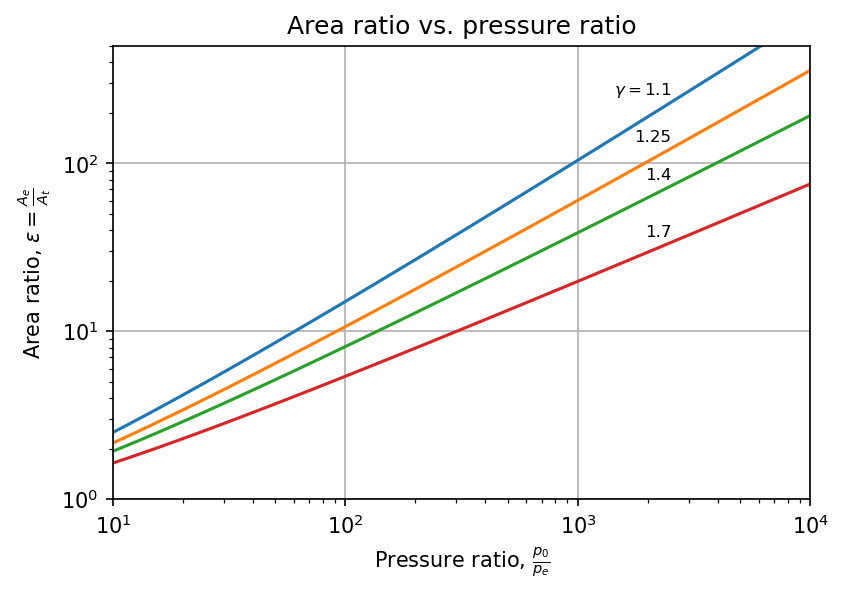

In [5]:
## area ratio as a function of pressure ratio

gammas = [1.1, 1.25, 1.4, 1.7]
pressure_ratios = np.logspace(1, 4, num=50)

labels = [r'$\gamma = 1.1$', '1.25', '1.4', '1.7']

# let's define a function to calculate area ratio based on gamma and the pressure ratio:
def calc_area_ratio(gamma, pressure_ratio):
    '''Calculates area ratio based on specific heat ratio and pressure ratio.
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return (
        np.power(2 / (gamma + 1), 1/(gamma-1)) * 
        np.power(pressure_ratio, 1 / gamma) *
        np.sqrt((gamma - 1) / (gamma + 1) /
                (1 - np.power(pressure_ratio, (1 - gamma)/gamma))
                )
        )

for gamma, label in zip(gammas, labels):
    area_ratios = calc_area_ratio(gamma, pressure_ratios)
    plt.plot(pressure_ratios, area_ratios)
    plt.text(
        0.9*pressure_ratios[-10], 1.01*area_ratios[-10], 
        label,
        horizontalalignment='right', fontsize=8
        )

plt.xlim([10, 1e4])
plt.ylim([1, 500])
plt.xlabel(r'Pressure ratio, $\frac{p_0}{p_e}$')
plt.ylabel(r'Area ratio, $\epsilon = \frac{A_e}{A_t}$')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.title('Area ratio vs. pressure ratio')
plt.show()

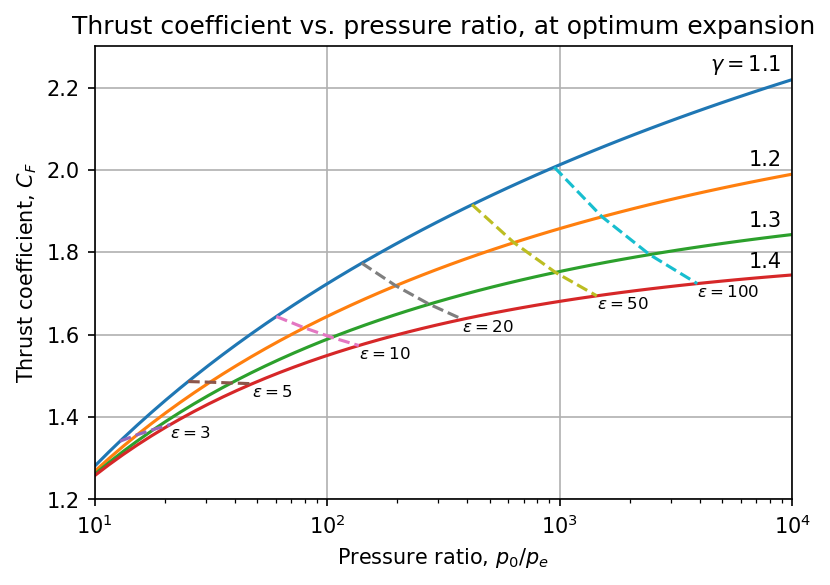

In [6]:
# Define a function to calculate thrust coefficient, assuming optimum expansion 
# (exit pressure = ambient pressure), based on gamma and pressure ratio:
def calc_thrust_coeff(gamma, pressure_ratio):
    ''' Calculates thrust coefficient for optimum expansion.
    pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return np.sqrt(
        2 * np.power(gamma, 2) / (gamma - 1) * 
        np.power(2 / (gamma + 1), (gamma + 1)/(gamma - 1)) * 
        (1 - np.power(1.0 / pressure_ratio, (gamma - 1)/gamma))
        )


# This function returns zero for a given area ratio, pressure ratio, and gamma,
#and is used to numerically calculate pressure ratio given the other two values.
def root_area_ratio(pressure_ratio, gamma, area_ratio):
    ''' pressure ratio: chamber / exit
    area ratio: exit / throat
    '''
    return area_ratio - calc_area_ratio(gamma, pressure_ratio)


gammas = [1.1, 1.2, 1.3, 1.4]
labels = [r'$\gamma = 1.1$', '1.2', '1.3', '1.4']
area_ratios = [3, 5, 10, 20, 50, 100]

pressure_ratios = np.logspace(1, 4, num=50)

for gamma, label in zip(gammas, labels):
    thrust_coeffs = calc_thrust_coeff(gamma, pressure_ratios)
    
    plt.plot(pressure_ratios, thrust_coeffs)
    plt.text(
        0.9*pressure_ratios[-1], 1.01*thrust_coeffs[-1], 
        label, horizontalalignment='right'
        )

for area_ratio in area_ratios:
    pressure_ratios2 = np.zeros(len(gammas))
    thrust_coeffs2 = np.zeros(len(gammas))
    for idx, gamma in enumerate(gammas):
        sol = root_scalar(root_area_ratio, x0=20, x1=100, args=(gamma, area_ratio))
        pressure_ratios2[idx] = sol.root
        thrust_coeffs2[idx] = calc_thrust_coeff(gamma, sol.root)
    
    plt.plot(pressure_ratios2, thrust_coeffs2, '--')
    plt.text(
        pressure_ratios2[-1], thrust_coeffs2[-1],
        r'$\epsilon =$' + f'{area_ratio}',
        horizontalalignment='left', verticalalignment='top', fontsize=8
        )
    
plt.xlim([10, 1e4])
plt.ylim([1.2, 2.3])
plt.xlabel(r'Pressure ratio, $p_0/p_e$')
plt.ylabel(r'Thrust coefficient, $C_F$')
plt.grid(True)
plt.xscale('log')
plt.title('Thrust coefficient vs. pressure ratio, at optimum expansion')
plt.show()

## Example: using equations to design optimal rocket nozzle

Using the above equations, design a rocket nozzle optimally for these conditions:
$p_c$ = 70 atm, $p_e$ = 1 atm, and $\gamma$ = 1.2.
Find the nozzle area ratio, and the rocket thrust as a function of nozzle exit area.

We know the pressure ratio:

$$
\frac{p_c}{p_e} = 70 \;,
$$

so we can directly calculate the nozzle area ratio:

$$
\frac{A_e}{A_t} = \epsilon = \left( \frac{2}{\gamma+1}\right)^{\frac{1}{\gamma-1}} \left( \frac{p_0}{p_e} \right)^{\frac{1}{\gamma}} \sqrt{ \frac{\gamma-1}{\gamma+1} \left[1 - \left( \frac{p_0}{p_e}\right)^{\frac{1-\gamma}{\gamma}} \right]^{-1} } \;.
$$ (area_ratio)

In [49]:
# set the given constants
chamber_pressure = Q_(70, 'atm')
exit_pressure = Q_(1, 'atm')
gamma = 1.2

pressure_ratio = chamber_pressure / exit_pressure

area_ratio = (
    np.power(2 / (gamma + 1), 1/(gamma-1)) * 
    np.power(pressure_ratio, 1 / gamma) *
    np.sqrt((gamma - 1) / (gamma + 1) /
        (1 - np.power(pressure_ratio, (1 - gamma)/gamma))
        )
    )
print(f'Nozzle area ratio: {area_ratio: 3.2f~P}')

Nozzle area ratio: 9.06


Since $p_e = p_a$ by design (for an optimal nozzle), we can calculate the thrust coefficient using:

$$
C_F = C_F^0 = \sqrt{\frac{2\gamma^2}{\gamma-1} \left( \frac{2}{\gamma+1} \right)^{\frac{\gamma+1}{\gamma-1}} \left[1 - \left( \frac{p_e}{p_0} \right)^{\frac{\gamma-1}{\gamma}} \right] }
$$ (thrust_coefficient)

and then thrust using:

$$
T = C_F^0 p_c A_e \frac{A_t}{A_e} \;.
$$

In [48]:
thrust_coeff = np.sqrt(
    2 * np.power(gamma, 2) / (gamma - 1) * 
    np.power(2 / (gamma + 1), (gamma + 1)/(gamma - 1)) * 
    (1 - np.power(1.0 / pressure_ratio, (gamma - 1)/gamma))
    )
print(f'Thrust coefficient = {thrust_coeff: 3.2f~P}')

thrust_per_area = thrust_coeff * chamber_pressure / area_ratio
print(f'Thrust = ({thrust_per_area.to("kPa"): 5.1f~P} * A_e)')

Thrust coefficient = 1.75
Thrust = (487.5 kPa * A_e)


We can now examine the thrust for a range of exit areas:

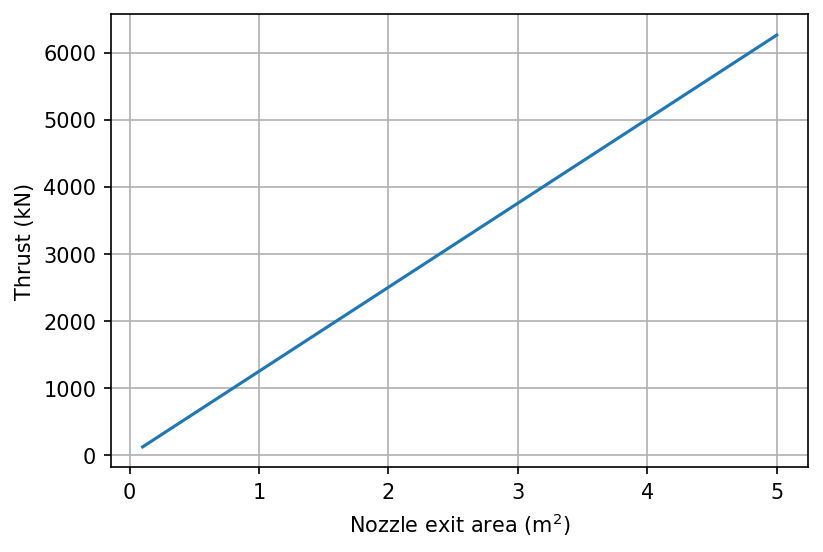

In [9]:
exit_areas = Q_(np.linspace(0.1, 5, num=50), 'm^2')
plt.plot(exit_areas.to('m^2').magnitude, (thrust_per_area * exit_areas).to('kN').magnitude)
plt.xlabel('Nozzle exit area ' + r'(m$^2$)')
plt.ylabel('Thrust (kN)')
plt.grid(True)
plt.show()

## Example for design of a rocket

In [10]:
# given constants
altitude = Q_(10000, 'm')
c_star = Q_(1500, 'm/s')
gamma = 1.2
MW = Q_(25, 'kg/kmol')
chamber_pressure = Q_(70, 'bar')
thrust_10k = Q_(100000, 'N')
burn_time = Q_(5, 's')

First, we need to calculate the nozzle pressure ratio, which requires obtaining the pressure at the rocket's flight altitude.

The 1976 U.S. Standard Atmosphere {cite}`standard_atmosphere_1976` is a model for how pressure, temperature, density, etc., vary
with altitude in the atmosphere, and provides reasonable answers for up to about 86 km.

The [`fluids` package](https://github.com/CalebBell/fluids) provides a convenient interface to this model in Python {cite}`fluids`,
along with other models such as the NRLMSISE-00 model {cite}`Picone2002`, which applies up to 1000 km.

Let's look at how temperature and pressure vary with altitude, using this model:

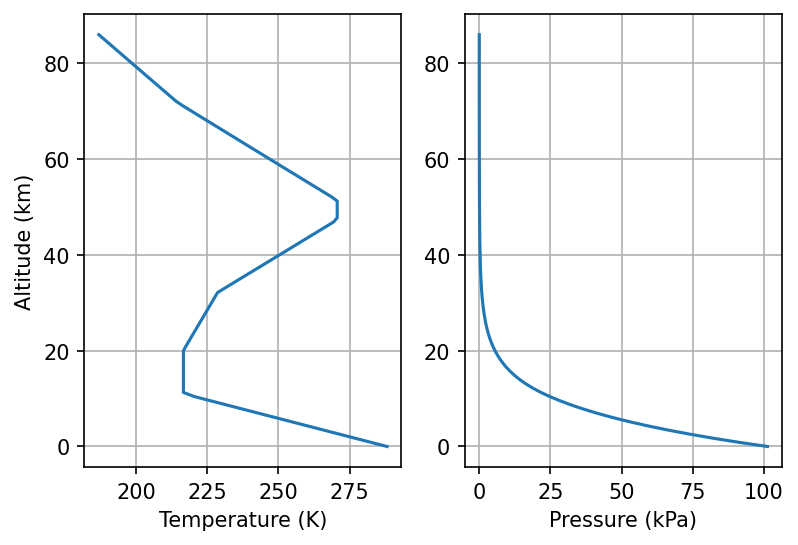

In [11]:
altitudes = np.linspace(0, 86000, num=100)
temperatures = np.zeros(len(altitudes))
pressures = np.zeros(len(altitudes))
for idx, h in enumerate(altitudes):
    atm = ATMOSPHERE_1976(h)
    temperatures[idx] = atm.T
    pressures[idx] = atm.P

fig, axes = plt.subplots(1, 2)

axes[0].plot(temperatures, altitudes/1000)
axes[0].set_xlabel('Temperature (K)')
axes[0].set_ylabel('Altitude (km)')
axes[0].grid(True)
    
axes[1].plot(pressures/1000, altitudes/1000)
axes[1].set_xlabel('Pressure (kPa)')
axes[1].grid(True)
plt.show()

We can use this to obtain the pressure at the flight altitude, and calculate pressure ratio:

$$
\frac{p_c}{p_e}
$$

In [12]:
# use model for 1976 US Standard Atmosphere to get pressure at altitude
ten_km = ATMOSPHERE_1976(to_si(altitude))
exit_pressure = Q_(ten_km.P, 'Pa')
print(f'Pressure at {altitude.to("km")}: {exit_pressure: .0f}')

pressure_ratio = chamber_pressure / exit_pressure
print(f'Pressure ratio (p_c/p_e): {pressure_ratio.to_base_units(): .1f}')

Pressure at 10.0 kilometer: 26500 pascal
Pressure ratio (p_c/p_e): 264.2 dimensionless


Next, we can calculate the nozzle area ratio and thrust coefficient (for optimum expansion, since $p_e = p_a$):

$$
\begin{align*}
\frac{A_e}{A_t} &= f \left( \gamma, \frac{p_c}{p_e} \right) \\
C_F &= C_F^0 = g \left( \gamma, \frac{p_c}{p_e} \right) \\
\end{align*}
$$

which are defined in Equations {eq}`area_ratio` and {eq}`thrust_coefficient` above—and we have already written functions to evaluate them!.

In [21]:
area_ratio = calc_area_ratio(gamma, pressure_ratio)
print(f'Area ratio: {area_ratio.to_base_units(): .2f~P}')

thrust_coeff = calc_thrust_coeff(gamma, pressure_ratio)
print(f'Thrust coefficient: {thrust_coeff.to_base_units(): .2f~P}')

Area ratio: 25.10
Thrust coefficient: 1.75


In [28]:
throat_area = thrust_10k / (thrust_coeff * chamber_pressure)
print(f'Throat area: {throat_area.to("m^2"): .4f~P}')

throat_diameter = 2 * np.sqrt(throat_area / np.pi)
print(f'Throat diameter: {throat_diameter.to("m"): .3f~P}')

Throat area: 0.0082 m²
Throat diameter: 0.102 m


In [30]:
exit_area = area_ratio * throat_area
print(f'Exit area: {exit_area.to("m^2"): .2e~P}')

exit_diameter = 2 * np.sqrt(exit_area / np.pi)
print(f'Exit diameter: {exit_diameter.to("m"): .3f~P}')

Exit area: 2.05e-01 m²
Exit diameter: 0.511 m


In [35]:
mass_flow_rate = chamber_pressure * throat_area / c_star
print(f'Mass flow rate: {mass_flow_rate.to("kg/s"): .2f~P}')

Mass flow rate: 38.14 kg/s


In [36]:
specific_impulse = c_star * thrust_coeff / Q_(constants.g, 'm/s^2')
print(f'Specific impulse: {specific_impulse.to("s"): .1f~P}')

Specific impulse: 267.3 s


In [38]:
propellant_mass = mass_flow_rate * burn_time
print(f'Propellant mass: {propellant_mass.to("kg"): .1f~P}')

Propellant mass: 190.7 kg


In [41]:
# constant.R is given in J/(K mol), need J/(K kmol)
chamber_temperature = (
    c_star**2 * gamma * (MW / Q_(constants.R, 'J/(K*mol)')) * 
    np.power(2 / (gamma+1), (gamma+1)/(gamma-1))
    )
print(f'Chamber temperature: {chamber_temperature.to("K"): .1f~P}')

Chamber temperature: 2845.4 K


In [43]:
# Thrust at sea level
thrust_coeff_sea_level = thrust_coeff + area_ratio * (
    1/pressure_ratio - Q_(1, 'atm')/chamber_pressure
    )
thrust_sea_level = thrust_coeff_sea_level * chamber_pressure * throat_area
print(f'Thrust at sea level: {thrust_sea_level.to("kN"): .1f~P}')

Thrust at sea level: 84.7 kN
